#### <left>Бронников Максим Андреевич</left>

max120199@gmail.com

#   <center>Домашняя работа №4</center>

## <center> Необходимо построить линейнейный классификатор по первой части набора данных и сделать прогноз о принадлежности объекта наблюдения к одном из классов для второй части набора данных </center>

### Подключим необходимые библиотеки

Для обработки данных нам пригодится визуализация, которую обеспечит библиотека `matplotlib.pyplot` вкупе с модулем `ListedColormap` для визуаллизации классов и библиотека `seaborn` которая отлично работает с визуализацией статистических данных. Библиотека `pandas` позволит нам обработать набор данных и сохранить их в *DataFrame*, а с помощью библиотеки `numpy` реализуем математическую составляющую построения линейного классификатора в матричном виде

In [1]:
import numpy as np 
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score, cross_validate

import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### Импортируем набор данных

In [2]:
dataset = pd.read_csv("input/train.csv")

dataset.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Survived
count,850.000000,850.000000,686.000000,850.000000,850.000000,849.000000,850.000000
mean,656.848235,2.295294,29.850583,0.470588,0.368235,33.507121,0.382353
std,371.701600,0.832837,14.141324,0.954664,0.865340,53.553686,0.486248
min,1.000000,1.000000,0.330000,0.000000,0.000000,0.000000,0.000000
25%,340.750000,2.000000,21.000000,0.000000,0.000000,7.895800,0.000000
50%,657.000000,3.000000,28.000000,0.000000,0.000000,14.400000,0.000000
75%,969.750000,3.000000,38.000000,1.000000,0.000000,30.500000,1.000000
max,1308.000000,3.000000,80.000000,8.000000,9.000000,512.329200,1.000000


### Получим еще больше информации о наборе

Получим дополнительную информацию типах и значениях колонок при помощи метода `info`, а также отобразив первые наблюдения таблицы с помощью `head`

In [3]:
print(dataset.info())
dataset.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 12 columns):
PassengerId    850 non-null int64
Pclass         850 non-null int64
Name           850 non-null object
Sex            850 non-null object
Age            686 non-null float64
SibSp          850 non-null int64
Parch          850 non-null int64
Ticket         850 non-null object
Fare           849 non-null float64
Cabin          182 non-null object
Embarked       850 non-null object
Survived       850 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 79.8+ KB
None


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,888,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1
1,1249,3,"Lockyer, Mr. Edward",male,NaN,0,0,1222,7.8792,NaN,S,0
2,1240,2,"Giles, Mr. Ralph",male,24.0,0,0,248726,13.5000,NaN,S,0
3,221,3,"Sunderland, Mr. Victor Francis",male,16.0,0,0,SOTON/OQ 392089,8.0500,NaN,S,1
4,1105,2,"Howard, Mrs. Benjamin (Ellen Truelove Arman)",female,60.0,1,0,24065,26.0000,NaN,S,0


#### Работаем с полом пассажиров

Получим информацию о уникальных значениях столбца `Sex` нашего *DataFrame* и подсчитаем процент женщин среди выживших, а также процент женщин на борту получения хоть какой-то информации о влиянии этого столбца на результирующий стобец

Уникальных элементов: 2
Элементы: ['female' 'male']
Процент женщин среди пассажиров:34.8235294117647%
Процент женщин среди выживших:68.0%


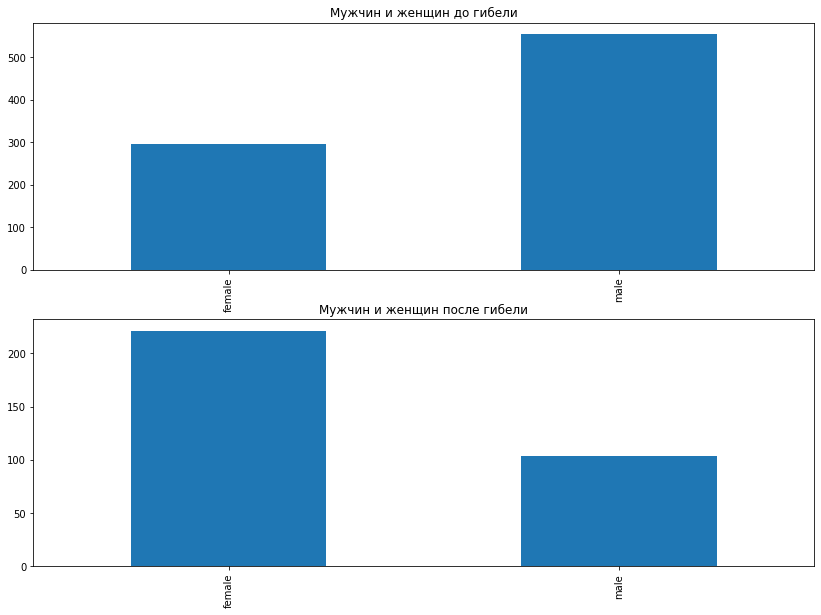

In [4]:
print("Уникальных элементов:", dataset.Sex.nunique())
print("Элементы:", dataset.Sex.unique())

fig = plt.figure(figsize= (14,10))
ax1 = fig.add_subplot(211)
ax1.set_title('Мужчин и женщин до гибели')
ax2 = fig.add_subplot(212)
ax2.set_title('Мужчин и женщин после гибели')


dev_sum = dataset[dataset.Sex == 'female'].shape[0] / dataset.shape[0]

dataset.Sex.value_counts()[['female', 'male']].plot.bar(ax = ax1)
print(r'Процент женщин среди пассажиров:{}%'.format(dev_sum * 100))


dev_sum = dataset.Survived[dataset.Sex == 'female'].sum() / dataset.Survived.sum()

dataset.Sex[dataset.Survived == 1].value_counts()[['female', 'male']].plot.bar(ax = ax2)
print(r'Процент женщин среди выживших:{}%'.format(dev_sum * 100))

Мы видим что значения столбца `Sex` **нельзя игнорировать**, так как прослеживается явная зависимость между полом пасссажира и процентом выживаемости: шанс женщины выжить оказался выше.

Поэтому для последующей работы со столбцом отобразим его значения в числовые интерпритации: $ male = 0$, $female = 1$ и добавим новый столбец в таблицу с полученными значениями

In [5]:
dataset['Man'] = 1
logic_mask = (dataset.Sex == 'female')
dataset.Man[logic_mask] = 0
dataset.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,Man
0,888,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1,0
1,1249,3,"Lockyer, Mr. Edward",male,NaN,0,0,1222,7.8792,NaN,S,0,1
2,1240,2,"Giles, Mr. Ralph",male,24.0,0,0,248726,13.5000,NaN,S,0,1
3,221,3,"Sunderland, Mr. Victor Francis",male,16.0,0,0,SOTON/OQ 392089,8.0500,NaN,S,1,1
4,1105,2,"Howard, Mrs. Benjamin (Ellen Truelove Arman)",female,60.0,1,0,24065,26.0000,NaN,S,0,0


### Получим таблицу признаков

Получим результирующий столбец в виде `np.array` и удалим все нечисловые признаки

In [6]:
Y_train = dataset['Survived'].to_numpy().reshape(dataset.shape[0], 1)

dataset = dataset.drop(['PassengerId', 'Name', 'Embarked', 'Ticket', 'Cabin', 'Sex', 'Survived', 'Fare'], axis = 1)

dataset.head(10)

,Pclass,Age,SibSp,Parch,Man
0,1,19.0,0,0,0
1,3,NaN,0,0,1
2,2,24.0,0,0,1
3,3,16.0,0,0,1
4,2,60.0,1,0,0
5,3,9.0,4,2,1
6,3,18.0,0,0,0
7,1,41.0,0,0,0
8,3,16.0,1,3,1
9,2,40.0,0,0,0


### Заполним пропущенные данные в столбце Age и Fare

Заполним неизвестные данные колонок Age и Fare средними значениями по колонкам

In [7]:
print("Значения возраста в диапазоне от", dataset.Age[dataset.Age.notnull()].min(), \
      "до", dataset.Age[dataset.Age.notnull()].max())
dataset.Age[dataset.Age.isnull()] = dataset.Age[dataset.Age.notnull()].mean()
# dataset.Fare[dataset.Fare.isnull()] = dataset.Fare[dataset.Fare.notnull()].mean()


print(dataset.info())
dataset.head(15)

Значения возраста в диапазоне от 0.33 до 80.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 5 columns):
Pclass    850 non-null int64
Age       850 non-null float64
SibSp     850 non-null int64
Parch     850 non-null int64
Man       850 non-null int64
dtypes: float64(1), int64(4)
memory usage: 33.3 KB
None


,Pclass,Age,SibSp,Parch,Man
0,1,19.000000,0,0,0
1,3,29.850583,0,0,1
2,2,24.000000,0,0,1
3,3,16.000000,0,0,1
4,2,60.000000,1,0,0
5,3,9.000000,4,2,1
6,3,18.000000,0,0,0
7,1,41.000000,0,0,0
8,3,16.000000,1,3,1
9,2,40.000000,0,0,0


### Преобразуем признаки

Переведем признаки в numpy.array и нормализуем их.

In [8]:
X_train = dataset.to_numpy().reshape(dataset.shape)
print(X_train.shape)

# print("Not normilize:")
# print(X_train)

#X_train = (X_train - X_train.min(axis = 0)) / (X_train.max(axis = 0) - X_train.min(axis = 0))
X_train = (X_train - X_train.mean(axis = 0)) / X_train.std(axis = 0)

type(X_train)
# print("Normilize:")
# print(X_train)

(850, 5)


numpy.ndarray

### Поиск оптимальной модели

Сравним и выберем лучшую модель среди `LogisticRegression` и `KNeighborsClassifier` из библиотеки `scikit_leran` при помощи перебора гиперпараметров и сравнения их значений на кросс-валидации

Для логистической регрессии - это штраф на большие веса.

Для метода k ближайших соседей - это количество k соседей для анализа

In [9]:
from tqdm import tqdm

best_log_score = 0
best_log_model = None
best_log_param = 0.1

best_knn_score = 0
best_knn_model = None
best_knn_param = 0.1

best_model = None


C_range = np.array([0.001, 0.005, 0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
C_range = np.hstack((C_range, np.arange(1, 600)))

for C in tqdm(C_range):
    model = LogisticRegression(C=C)
    scor = cross_val_score(model, X_train, Y_train, cv=6, scoring="accuracy")
    mean_score = np.mean(scor)
    
    if mean_score > best_log_score:
        best_log_score = mean_score
        best_log_model = model
        best_log_param = C
        
print(f"Лучшие параметры для Логистической регрессии с точностью на валидации - {best_log_score:0.4f} и C={best_log_param}")


for i in tqdm(range(1, 70)):
    model = KNeighborsClassifier(n_neighbors=i)
    scor = cross_val_score(model, X_train, Y_train, cv=10, scoring="accuracy")
    mean_score = np.mean(scor)
    
    if mean_score > best_knn_score:
        best_knn_score = mean_score
        best_knn_model = model
        best_knn_param = i
        
print(f"Лучшик параметры для KNN метода с точностью на валидации - {best_knn_score:0.4f} и количеством соседей ={best_knn_param}")
if best_knn_score > best_log_score:
    best_model = best_knn_model
    print("Лучшая модель: Метод ближайших соседей")
else:
    best_model = best_log_model
    print("Лучшая модель: Логистическая регрессия")

  3%|▎         | 2/69 [00:00<00:05, 12.14it/s]

Лучшие параметры для Логистической регрессии с точностью на валидации - 0.7929 и C=0.04


100%|██████████| 69/69 [00:06<00:00, 10.52it/s]

Лучшик параметры для KNN метода с точностью на валидации - 0.8045 и количеством соседей =17
Лучшая модель: Метод ближайших соседей


In [10]:
#logreg_model = mean_best_model
logreg_model = best_model
logreg_model.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=17, p=2,
                     weights='uniform')

Лучшей моделью оказался метод k ближайших соседей

### Считаем и предобработаем данные тестовой выборки

Сделаем это по аналогии с тренировочной.

In [11]:
testset = pd.read_csv("input/test.csv")

testset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459 entries, 0 to 458
Data columns (total 11 columns):
PassengerId    459 non-null int64
Pclass         459 non-null int64
Name           459 non-null object
Sex            459 non-null object
Age            360 non-null float64
SibSp          459 non-null int64
Parch          459 non-null int64
Ticket         459 non-null object
Fare           459 non-null float64
Cabin          113 non-null object
Embarked       457 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 39.6+ KB


In [12]:
testset['Man'] = 1
logic_mask = (testset.Sex == 'female')
testset.Man[logic_mask] = 0
testset.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Man
0,1167,2,"Bryhl, Miss. Dagmar Jenny Ingeborg",female,20.0,1,0,236853,26.00,NaN,S,0
1,1215,1,"Rowe, Mr. Alfred G",male,33.0,0,0,113790,26.55,NaN,S,1
2,823,1,"Reuchlin, Jonkheer. John George",male,38.0,0,0,19972,0.00,NaN,S,1
3,864,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S,0
4,11,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.70,G6,S,0


In [13]:
Pass_Id = testset['PassengerId']

testset = testset.drop(['PassengerId', 'Name', 'Embarked', 'Ticket', 'Cabin', 'Sex', 'Fare'], axis = 1)

testset.head(10)

,Pclass,Age,SibSp,Parch,Man
0,2,20.0,1,0,0
1,1,33.0,0,0,1
2,1,38.0,0,0,1
3,3,NaN,8,2,0
4,3,4.0,1,1,0
5,1,13.0,2,2,1
6,3,16.0,1,1,0
7,2,18.0,0,0,1
8,1,24.0,0,0,0
9,3,NaN,1,0,0


In [14]:
testset.Age[testset.Age.isnull()] = testset.Age[testset.Age.notnull()].mean()
#testset.Fare[testset.Fare.isnull()] = testset.Fare[testset.Fare.notnull()].mean()

print(testset.info())
testset.head(15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459 entries, 0 to 458
Data columns (total 5 columns):
Pclass    459 non-null int64
Age       459 non-null float64
SibSp     459 non-null int64
Parch     459 non-null int64
Man       459 non-null int64
dtypes: float64(1), int64(4)
memory usage: 18.1 KB
None


,Pclass,Age,SibSp,Parch,Man
0,2,20.000000,1,0,0
1,1,33.000000,0,0,1
2,1,38.000000,0,0,1
3,3,29.939361,8,2,0
4,3,4.000000,1,1,0
5,1,13.000000,2,2,1
6,3,16.000000,1,1,0
7,2,18.000000,0,0,1
8,1,24.000000,0,0,0
9,3,29.939361,1,0,0


In [15]:
X_test = testset.to_numpy().reshape(testset.shape)
print(X_test.shape)

#X_test = (X_test - X_test.min(axis = 0)) / (X_test.max(axis = 0) - X_test.min(axis = 0))
X_test = (X_test - X_test.mean(axis = 0)) / X_test.std(axis = 0)

#X_test = np.insert(X_test, 0, 1, axis = 1)
#print(X_test.shape)

(459, 5)


### Получим ответ

Результирующий столбец получим при помощи метода `predict` класса модели.

Переведем полученный ответ в *DataFrame* для перевода в `csv` формат.

In [16]:
Y_test = logreg_model.predict(X_test)
Y_test = Y_test.reshape(X_test.shape[0], 1)
Y_test
Ans = pd.DataFrame(Pass_Id)
Ans['Survived'] = Y_test
Ans.head(7)

,PassengerId,Survived
0,1167,1
1,1215,0
2,823,0
3,864,0
4,11,1
5,956,1
6,996,0


### Результат

Взглянем на полученный нами результат из файла `answer.csv`

In [17]:

Ans.to_csv("output/answer.csv", index = False)
sample = pd.read_csv('output/answer.csv')
sample.head()

,PassengerId,Survived
0,1167,1
1,1215,0
2,823,0
3,864,0
4,11,1


###### <center>Сделано Бронниковым Максимом</center>
###### <center>01.11.2019</center>